# Golden Section Search

In [24]:
import numpy as np
import typing
from numpy import typing as nptyping
import scipy as sp
import scipy.optimize as op
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
def golden_section(
    f: typing.Callable[[float], float],
    boundary: nptyping.ArrayLike,
    maxiter=500,
    tol=1e-5,
):
    r = (-1 + np.sqrt(5)) / 2  # golden ratio
    a = boundary[0]  # lower bound
    b = boundary[1]  # upper bound

    for _ in range(maxiter):
        h = b - a
        if abs(h) < tol:
            return (a + b) / 2
        lower = b - r * h
        upper = a + r * h

        if f(lower) > f(upper):
            a = lower
        else:
            b = upper

    print("Warning: Did not converge within given number of iteration.")
    return (a + b) / 2

3.9269887262718806


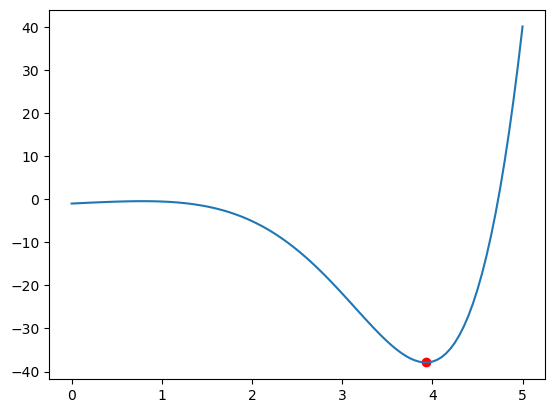

In [15]:
# Example of Golden Section Search
f = lambda x: np.exp(x) * np.cos(x) - 2
minimum = golden_section(f, [1, 5])
print(minimum)

xrange = np.linspace(0, 5, 101)
plt.plot(xrange, f(xrange))
plt.scatter(minimum, f(minimum), color="r")

# Gradient Descent

In [46]:
from differentiation import gradient


def gradient_descent(
    f: typing.Callable[[nptyping.ArrayLike], float],
    x0: nptyping.ArrayLike,
    grad_f=None,
    step=0.01,
    maxiter=10000,
    tol=1e-6,
    traj: bool = False,
) -> float:
    x = x0
    if grad_f is None:
        if traj:
            trajectory = np.empty((maxiter, 3))
            for i in range(maxiter):
                trajectory[i, 0:2] = x
                trajectory[i, 2] = f(x)
                if abs(np.linalg.norm(gradient(f, x), 2)) < tol:
                    return x, trajectory[: i + 1, :]

                x -= step * gradient(f, x)
            print("Warning: Did not converge within given number of iteration.")
            return x, trajectory
        else:
            for i in range(maxiter):
                if abs(np.linalg.norm(gradient(f, x), 2)) < tol:
                    return x

                x -= step * gradient(f, x)
            print("Warning: Did not converge within given number of iteration.")
            return x
    else:
        for _ in range(maxiter):
            if abs(np.linalg.norm(grad_f(x), 2)) < tol:
                return x

            x -= step * grad_f(f, x)
        print("Warning: Did not converge within given number of iteration.")
        return x

In [6]:
from differentiation import gradient


def gradient_descent2(f, x0: np.ndarray, grad_f=None, maxiter=100000, tol=1e-6):
    """
    Returns minimum optimized by gradient descent.
    Ver2 uses adaptive step size valid when:
    f is convex and grad(f) is Lipschitz continuous
    """
    if ~isinstance(x0, np.ndarray):
        x0 = np.array(x0)

    x_old = x0
    x = x_old + 0.5

    for _ in range(maxiter):
        if abs(np.linalg.norm(gradient(f, x), 2)) < tol:
            return x
        # Calculation of step is causing a problem
        step = abs(np.dot((x - x_old).T, (gradient(f, x) - gradient(f, x_old))))
        step /= np.linalg.norm(gradient(f, x) - gradient(f, x_old)) ** 2

        x_old = x
        x -= step * gradient(f, x)
    print("Warning: Did not converge within given number of iteration.")
    return x

550


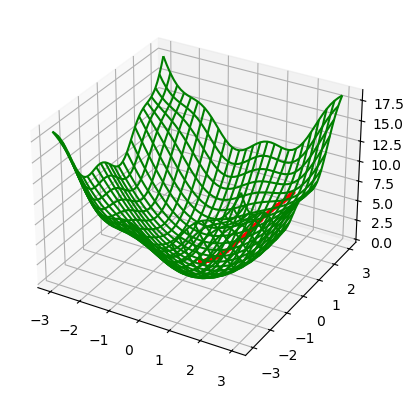

In [47]:
def my_func(x_vect: nptyping.ArrayLike):
    x = x_vect[0]
    y = x_vect[1]
    return x**2 + y**2 + np.sin(x * y)


minimum, traj = gradient_descent(my_func, [2.0, 2.0], traj=True)

fig = plt.figure()
ax = plt.axes(projection="3d")
xrange = np.linspace(-3, 3, 51)
yrange = np.linspace(-3, 3, 51)
xgrid, ygrid = np.meshgrid(xrange, yrange)
zgrid = my_func([xgrid, ygrid])

ax.plot_wireframe(xgrid, ygrid, zgrid, color="green")
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], "ro-", markersize=2)
print(len(traj))

# Nelder-Mead Method

In [8]:
# All vectors in column vector form!
def _centroid(X):
    n = len(X)
    x0 = np.sum(X[:, :-1], axis=1) / n
    return x0


def _reflection(x0, X, alpha):
    x_r = x0 + alpha * (x0 - X[:, -1])
    return x_r


def _expansion(x0, x_r, gamma):
    x_e = x0 + gamma * (x_r - x0)
    return x_e


def _contraction_out(x0, x_r, rho):
    x_c = x0 + rho * (x_r - x0)
    return x_c


def _contraction_in(x0, X, rho):
    x_c = x0 + rho * (X[:, -1] - x0)
    return x_c


def _shrink(X, phi):
    X_shrink = X[:, 0] + phi * (X - X[:, 0])
    return X_shrink


def nelder_mead(f, X0, alpha=1, gamma=2, rho=0.5, phi=0.5, maxiter=1e5, tol=1e-6):
    """
    Returns minimum optimized by Nelder-Mead method.
    """
    n = len(X0)
    X = X0
    for iter in range(int(maxiter)):
        sort_idx = np.argsort(f(X))
        X = np.array([X[:, i] for i in sort_idx]).T

        # print(f"iteration#{iter} >> {X[:, 0]}")
        # print(f"error >> {np.std(f(X))}")

        if np.std(f(X)) < tol:
            return X[:, 0]

        x0 = _centroid(X)
        x_r = _reflection(x0, X, alpha)
        if f(x_r) >= f(X[:, 0]) and f(x_r) < f(X[:, -2]):
            X[:, -1] = x_r
        elif f(x_r) < f(X[:, 0]):
            x_e = _expansion(x0, x_r, gamma)
            if f(x_e) < f(x_r):
                X[:, -1] = x_e
            else:
                X[:, -1] = x_r
        else:
            if f(x_r) < f(X[:, -1]):  # Outside the simplex
                x_c = _contraction_out(x0, x_r, rho)
                if f(x_c) < f(x_r):
                    X[:, -1] = x_c
                else:
                    X = _shrink(X, phi)
            else:  # Inside the simplex
                x_c = _contraction_in(x0, X, rho)
                if f(x_c) < f(X[:, -1]):
                    X[:, -1] = x_c
                else:
                    X = _shrink(X, phi)
    print("Warning: Did not converge within given number of iteration.")
    return X[:, 0]

In [9]:
# Example of Nelder-Mead method
def my_func(x_vect: nptyping.ArrayLike):
    x = x_vect[0]
    y = x_vect[1]
    return x * y * np.exp(-(x**2 + y**2))


X0 = np.array([[1.0, 2.0], [1.5, 2.5], [2.0, 3.0]]).T * (-0.1)
root = nelder_mead(my_func, X0)
root2 = op.minimize(my_func, [-1.0, -2.0], method="Nelder-Mead")
print(root)
print(root2)

[ 0.04940491 -0.05059509]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0
             x: [-3.345e+00 -2.885e+01]
           nit: 30
          nfev: 94
 final_simplex: (array([[-3.345e+00, -2.885e+01],
                       [-3.345e+00, -2.885e+01],
                       [-3.345e+00, -2.885e+01]]), array([ 0.000e+00,  0.000e+00,  0.000e+00]))


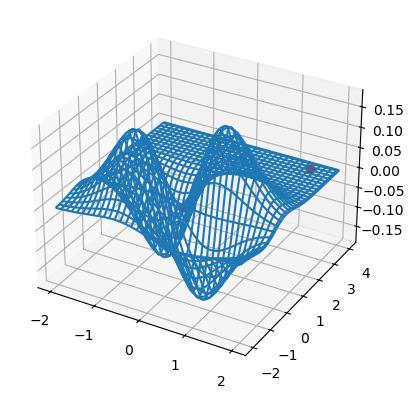

In [10]:
# Take a look at the objective function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-2, 2, 101)
y = np.linspace(-2, 4, 101)

xgrid, ygrid = np.meshgrid(x, y)
zgrid = my_func([xgrid, ygrid])

figure = plt.figure()
ax = plt.axes(projection="3d", proj_type="persp")
ax.plot_wireframe(xgrid, ygrid, zgrid, cmap="winter")
ax.plot(0.04940491, -0.05059509, my_func([0.04940491, -0.05059509]), c="r", marker="o")
ax.plot(1.474e00, 3.625e00, my_func([1.474e00, 3.625e00]), c="r", marker="o")